# Useful Notebook: Re-Evaluate Models Training Data Performance Using an Alternative Decision Threshold
**This notebook will allow users to (1) re-evaluate all trained models on respective training datasets using the standard decision threshold of 0.5 or some other threshold, (2) re-generate metric evaluation boxplots comparing algorithm performance using this new decision threshold, and (3) re-run statistical significance analyses comparing algorithm performance using this new decision threshold.**

*This notebook is designed to run after having run STREAMLINE (at least phases 1-6) and will use the files from a specific STREAMLINE experiment folder, as well as save new output files to that same folder.*

***
## Notebook Details
Allows users to specify alternative decision thresholds (rather than the standard 0.5 probability) and re-evaluate algorithm performane metrics.

Unlike the main pipeline all results output by this notebook are based on the training performance. This script can be used to evaluate and report training data evaluation metrics using different decision threshold. This notebook can also be used to simply obtain training evaluation metrics for the entire pipeline that correspond to the testing output by setting the threshold parameter to 0.5. 

All files will be saved in a single new folder in the experiment folder for each target dataset (i.e. `model_training_evaluation`). Also outputs new metric boxplots, ROC, and PRC plots, but now for training performance rather than testing performance.
 

***
## Notebook Run Parameters
* This notbook has been set up to run 'as-is' on the experiment folder generated when running the demo of STREAMLINE in any mode (if no run parameters were changed).
* If you have run STREAMLINE on different target data or saved the experiment to some other folder outside of STREAMLINE, you need to edit `experiment_path` below to point to the respective experiment folder.

In [1]:
experiment_path = "../DemoOutput/demo_experiment" # path the target experiment folder 
targetDataName = None # 'None' if user wants to generate visualizations for all analyzed datasets or specify (str) list of target dataset names
algorithms = [] # use empty list if user wishes re-evaluate all modeling algorithms that were run in pipeline.
threshold = 0.5 # Threshold of case probability used to predict case (typically 0.5 by default in modeling)
plot_metric_boxplots = True #Plot new boxplots for each metric using new threshold.
run_sig_test = True # Rerun non-parametric significance testing between all algorithms for each metric.
name_modifier = '_T_'+str(threshold) # Modifies names of stats files to avoid overwriting originals (This can be left as is or altered)
plot_ROC = True #Plot ROC for training data 
plot_PRC = True #Plot PRC for training data
#available_algorithms = ['Naive Bayes','Logistic Regression','Decision Tree','Random Forest','Gradient Boosting','XGB','LGB','SVM','ANN','K Neighbors','eLCS','XCS','ExSTraCS']

***
## Housekeeping
### Import Packages

In [2]:
import os
import pandas as pd
import pickle
import copy
from statistics import mean,stdev
import numpy as np
from scipy import interp,stats
# Evalutation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn import metrics
import csv
import matplotlib.pyplot as plt
import pickle

import warnings
warnings.filterwarnings('ignore')

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Automatically detect data folder names

In [3]:
# Get dataset paths for all completed dataset analyses in experiment folder
datasets = os.listdir(experiment_path)

# Name of experiment folder
experiment_name = experiment_path.split('/')[-1] 

datasets = os.listdir(experiment_path)
remove_list = ['.DS_Store', 'metadata.pickle', 'metadata.csv', 'algInfo.pickle',
                'DatasetComparisons', 'jobs', 'jobsCompleted', 'logs',
                'KeyFileCopy', 'dask_logs',
                experiment_name + '_ML_Pipeline_Report.pdf']
for text in remove_list:
    if text in datasets:
        datasets.remove(text)

datasets = sorted(datasets) # ensures consistent ordering of datasets
print("Analyzed Datasets: " + str(datasets))

Analyzed Datasets: ['hcc_data', 'hcc_data_custom']


### Load other necessary parameters

In [4]:
# Unpickle metadata from previous phase
file = open(experiment_path+'/'+"metadata.pickle", 'rb')
metadata = pickle.load(file)
file.close()
# Load variables specified earlier in the pipeline from metadata
class_label = metadata['Class Label']
instance_label = metadata['Instance Label']
cv_partitions = int(metadata['CV Partitions'])
sig_cutoff =float(metadata['Statistical Significance Cutoff'])
primary_metirc = metadata['Primary Metric']

#Unpickle algorithm information from previous phase
file = open(experiment_path+'/'+"algInfo.pickle", 'rb')
algInfo = pickle.load(file)
file.close()
algorithms = []
abbrev = {}
colors = {}
for key in algInfo:
    if algInfo[key][0]: # If that algorithm was used
        algorithms.append(key)
        abbrev[key] = (algInfo[key][1])
        colors[key] = (algInfo[key][2])
print("Analyzed Datasets: " + str(datasets))

Analyzed Datasets: ['hcc_data', 'hcc_data_custom']


## Define Necessary Methods

In [5]:
def classEval(y_true, y_pred):
    """ Calculates standard classification metrics including:
    True positives, false positives, true negative, false negatives, standard accuracy, balanced accuracy
    recall, precision, f1 score, negative predictive value, likelihood ratio positive, and likelihood ratio negative"""
    #Calculate true positive, true negative, false positive, and false negative.
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    #Calculate Accuracy metrics
    ac = accuracy_score(y_true, y_pred)
    bac = balanced_accuracy_score(y_true, y_pred)
    #Calculate Precision and Recall
    re = recall_score(y_true, y_pred)
    pr = precision_score(y_true, y_pred)
    #Calculate F1 score
    f1 = f1_score(y_true, y_pred)
    # Calculate specificity
    if tn == 0 and fp == 0:
        sp = 0
    else:
        sp = tn / float(tn + fp)
    # Calculate Negative predictive value
    if tn == 0 and fn == 0:
        npv = 0
    else:
        npv = tn/float(tn+fn)
    # Calculate likelihood ratio postive
    if sp == 1:
        lrp = 0
    else:
        lrp = re/float(1-sp)
    # Calculate likeliehood ratio negative
    if sp == 0:
        lrm = 0
    else:
        lrm = (1-re)/float(sp)
    return [bac, ac, f1, re, sp, pr, tp, tn, fp, fn, npv, lrp, lrm]

In [6]:
def saveMetricMeans(full_path,metrics,metric_dict,name_modifier):
    """ Exports csv file with average metric values (over all CVs) for each ML modeling algorithm"""
    with open(full_path+'/model_training_evaluation/Summary_performance_mean'+name_modifier+'.csv',mode='w', newline="") as file:
        writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        e = ['']
        e.extend(metrics)
        writer.writerow(e) #Write headers (balanced accuracy, etc.)
        for algorithm in metric_dict:
            astats = []
            for l in list(metric_dict[algorithm].values()):
                l = [float(i) for i in l]
                meani = mean(l)
                std = stdev(l)
                astats.append(str(meani))
            toAdd = [algorithm]
            toAdd.extend(astats)
            writer.writerow(toAdd)
    file.close()

In [7]:
def saveMetricStd(full_path,metrics,metric_dict,name_modifier):
    """ Exports csv file with metric value standard deviations (over all CVs) for each ML modeling algorithm"""
    with open(full_path + '/model_training_evaluation/Summary_performance_std'+name_modifier+'.csv', mode='w', newline="") as file:
        writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        e = ['']
        e.extend(metrics)
        writer.writerow(e)  # Write headers (balanced accuracy, etc.)
        for algorithm in metric_dict:
            astats = []
            for l in list(metric_dict[algorithm].values()):
                l = [float(i) for i in l]
                std = stdev(l)
                astats.append(str(std))
            toAdd = [algorithm]
            toAdd.extend(astats)
            writer.writerow(toAdd)
    file.close()

In [8]:
def metricBoxplots(full_path,metrics,algorithms,metric_dict,name_modifier):
    """ Export boxplots comparing algorithm performance for each standard metric"""
    if not os.path.exists(full_path + '/model_training_evaluation/metricBoxplots'):
        os.mkdir(full_path + '/model_training_evaluation/metricBoxplots')
    for metric in metrics:
        tempList = []
        for algorithm in algorithms:
            tempList.append(metric_dict[algorithm][metric])
        td = pd.DataFrame(tempList)
        td = td.transpose()
        td.columns = algorithms
        #Generate boxplot
        boxplot = td.boxplot(column=algorithms,rot=90)
        #Specify plot labels
        plt.ylabel(str(metric))
        plt.xlabel('ML Algorithm')
        #Export and/or show plot
        plt.savefig(full_path + '/model_training_evaluation/metricBoxplots/Compare_'+metric+name_modifier+'.png', bbox_inches="tight")
        plt.show()

In [9]:
def kruskalWallis(full_path,metrics,algorithms,metric_dict,sig_cutoff,name_modifier):
    """ Apply non-parametric Kruskal Wallis one-way ANOVA on ranks. Determines if there is a statistically significant difference in algorithm performance across CV runs.
    Completed for each standard metric separately."""
    # Create directory to store significance testing results (used for both Kruskal Wallis and MannWhitney U-test)
    if not os.path.exists(full_path + '/model_training_evaluation/statistical_comparisons'):
        os.mkdir(full_path + '/model_training_evaluation/statistical_comparisons')
    #Create dataframe to store analysis results for each metric
    label = ['Statistic', 'P-Value', 'Sig(*)']
    kruskal_summary = pd.DataFrame(index=metrics, columns=label)
    #Apply Kruskal Wallis test for each metric
    for metric in metrics:
        tempArray = []
        for algorithm in algorithms:
            tempArray.append(metric_dict[algorithm][metric])
        try:
            result = stats.kruskal(*tempArray)
        except:
            result = [tempArray[0],1]
        kruskal_summary.at[metric, 'Statistic'] = str(round(result[0], 6))
        kruskal_summary.at[metric, 'P-Value'] = str(round(result[1], 6))
        if result[1] < sig_cutoff:
            kruskal_summary.at[metric, 'Sig(*)'] = str('*')
        else:
            kruskal_summary.at[metric, 'Sig(*)'] = str('')
    #Export analysis summary to .csv file
    kruskal_summary.to_csv(full_path + '/model_training_evaluation/statistical_comparisons/KruskalWallis'+name_modifier+'.csv')
    return kruskal_summary

In [10]:
def wilcoxonRank(full_path,metrics,algorithms,metric_dict,kruskal_summary,sig_cutoff,name_modifier):
    """ Apply non-parametric Wilcoxon signed-rank test (pairwise comparisons). If a significant Kruskal Wallis algorithm difference was found for a given metric, Wilcoxon tests individual algorithm pairs
    to determine if there is a statistically significant difference in algorithm performance across CV runs. Test statistic will be zero if all scores from one set are
    larger than the other."""
    for metric in metrics:
        if kruskal_summary['Sig(*)'][metric] == '*':
            wilcoxon_stats = []
            done = []
            for algorithm1 in algorithms:
                for algorithm2 in algorithms:
                    if not [algorithm1,algorithm2] in done and not [algorithm2,algorithm1] in done and algorithm1 != algorithm2:
                        set1 = metric_dict[algorithm1][metric]
                        set2 = metric_dict[algorithm2][metric]
                        #handle error when metric values are equal for both algorithms
                        combined = copy.deepcopy(set1)
                        combined.extend(set2)
                        if all(x==combined[0] for x in combined): #Check if all nums are equal in sets
                            report = ['NA',1]
                        else: # Apply Wilcoxon Rank Sum test
                            report = stats.wilcoxon(set1,set2)
                        #Summarize test information in list
                        tempstats = [algorithm1,algorithm2,report[0],report[1],'']
                        if report[1] < sig_cutoff:
                            tempstats[4] = '*'
                        wilcoxon_stats.append(tempstats)
                        done.append([algorithm1,algorithm2])
            #Export test results
            wilcoxon_stats_df = pd.DataFrame(wilcoxon_stats)
            wilcoxon_stats_df.columns = ['Algorithm 1', 'Algorithm 2', 'Statistic', 'P-Value', 'Sig(*)']
            wilcoxon_stats_df.to_csv(full_path + '/model_training_evaluation/statistical_comparisons/WilcoxonRank_'+metric+name_modifier+'.csv', index=False)

In [11]:
def mannWhitneyU(full_path,metrics,algorithms,metric_dict,kruskal_summary,sig_cutoff,name_modifier):
    """ Apply non-parametric Mann Whitney U-test (pairwise comparisons). If a significant Kruskal Wallis algorithm difference was found for a given metric, Mann Whitney tests individual algorithm pairs
    to determine if there is a statistically significant difference in algorithm performance across CV runs. Test statistic will be zero if all scores from one set are
    larger than the other."""
    for metric in metrics:
        if kruskal_summary['Sig(*)'][metric] == '*':
            mann_stats = []
            done = []
            for algorithm1 in algorithms:
                for algorithm2 in algorithms:
                    if not [algorithm1,algorithm2] in done and not [algorithm2,algorithm1] in done and algorithm1 != algorithm2:
                        set1 = metric_dict[algorithm1][metric]
                        set2 = metric_dict[algorithm2][metric]
                        #handle error when metric values are equal for both algorithms
                        combined = copy.deepcopy(set1)
                        combined.extend(set2)
                        if all(x==combined[0] for x in combined): #Check if all nums are equal in sets
                            report = ['NA',1]
                        else: #Apply Mann Whitney U test
                            report = stats.mannwhitneyu(set1,set2)
                        #Summarize test information in list
                        tempstats = [algorithm1,algorithm2,report[0],report[1],'']
                        if report[1] < sig_cutoff:
                            tempstats[4] = '*'
                        mann_stats.append(tempstats)
                        done.append([algorithm1,algorithm2])
            #Export test results
            mann_stats_df = pd.DataFrame(mann_stats)
            mann_stats_df.columns = ['Algorithm 1', 'Algorithm 2', 'Statistic', 'P-Value', 'Sig(*)']
            mann_stats_df.to_csv(full_path + '/model_training_evaluation/statistical_comparisons/MannWhitneyU_'+metric+name_modifier+'.csv', index=False)

In [12]:
def doPlotROC(result_table,colors,full_path):
    """ Generate ROC plot comparing average ML algorithm performance (over all CV training/testing sets)"""
    count = 0
    #Plot curves for each individual ML algorithm
    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'],result_table.loc[i]['tpr'], color=colors[i],label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
        count += 1
    # Set figure dimensions
    plt.rcParams["figure.figsize"] = (6,6)
    # Plot no-skill line
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--', label='No-Skill', alpha=.8)
    #Specify plot axes,labels, and legend
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)
    plt.legend(loc="upper left", bbox_to_anchor=(1.01,1))
    #Export and/or show plot
    plt.savefig(full_path+'/model_training_evaluation/Summary_ROC.png', bbox_inches="tight")
    plt.show()

In [13]:
def doPlotPRC(result_table,colors,full_path,data_name,instance_label,class_label):
    """ Generate PRC plot comparing average ML algorithm performance (over all CV training/testing sets)"""
    count = 0
    #Plot curves for each individual ML algorithm
    for i in result_table.index:
        plt.plot(result_table.loc[i]['recall'],result_table.loc[i]['prec'], color=colors[i],label="{}, AUC={:.3f}, APS={:.3f}".format(i, result_table.loc[i]['pr_auc'],result_table.loc[i]['ave_prec']))
        count += 1
    #Estimate no skill line based on the fraction of cases found in the first test dataset
    test = pd.read_csv(full_path+'/CVDatasets/'+data_name+'_CV_0_Train.csv')
    if instance_label != 'None':
        test = test.drop(instance_label, axis=1)
    testY = test[class_label].values
    noskill = len(testY[testY == 1]) / len(testY)  # Fraction of cases
    # Plot no-skill line
    plt.plot([0, 1], [noskill, noskill], color='orange', linestyle='--',label='No-Skill', alpha=.8)
    #Specify plot axes,labels, and legend
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("Recall (Sensitivity)", fontsize=15)
    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("Precision (PPV)", fontsize=15)
    plt.legend(loc="upper left", bbox_to_anchor=(1.01,1))
    #Export and/or show plot
    plt.savefig(full_path+'/model_training_evaluation/Summary_PRC.png', bbox_inches="tight")
    plt.show()


## Run Training Evaluation and Generate Metric Boxplots and ROC and PRC Plots

Vizualized Datasets: ['hcc_data_custom']
---------------------------------------
hcc_data_custom
---------------------------------------


(-0.05, 1.05)

(-0.05, 1.05)

Text(0.5, 1.0, 'Decision Tree')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

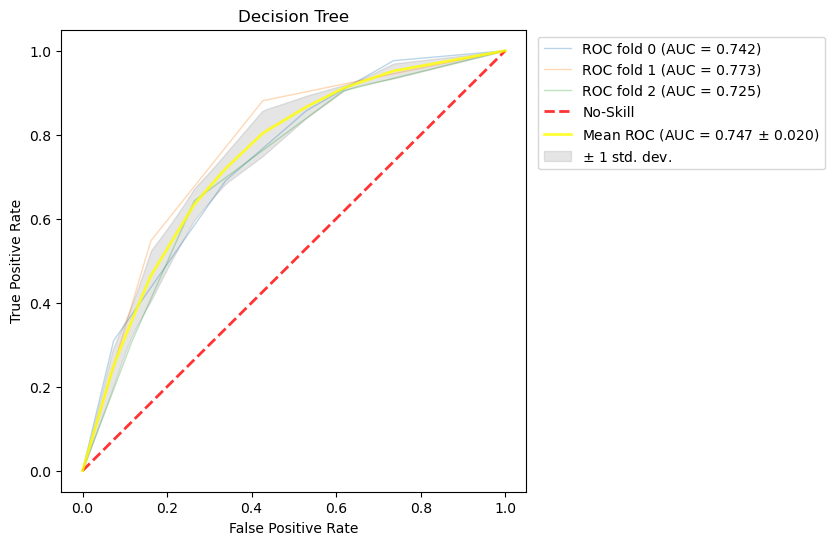

(-0.05, 1.05)

(-0.05, 1.05)

Text(0.5, 1.0, 'Decision Tree')

Text(0.5, 0, 'Recall (Sensitivity)')

Text(0, 0.5, 'Precision (PPV)')

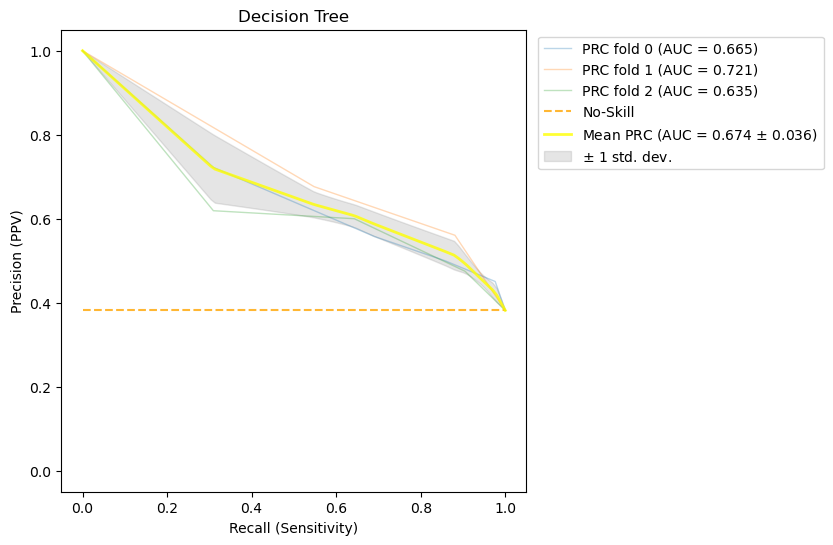

(-0.05, 1.05)

(-0.05, 1.05)

Text(0.5, 1.0, 'Logistic Regression')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

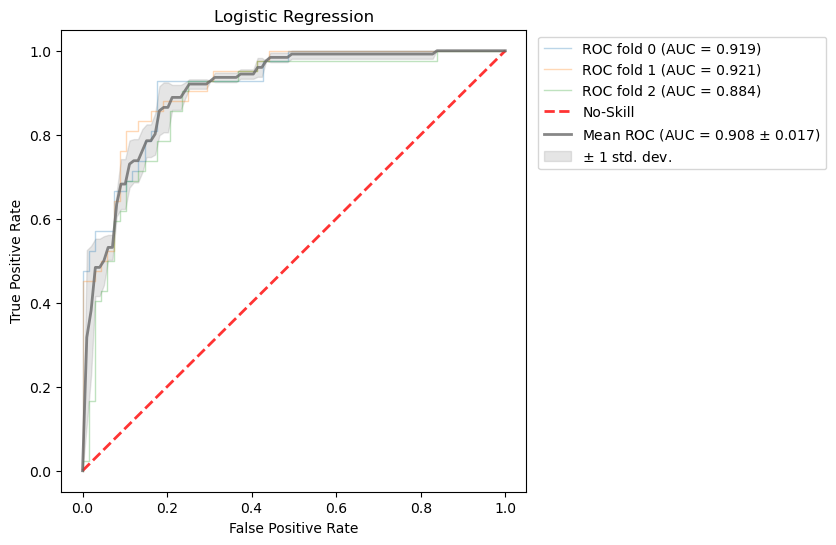

(-0.05, 1.05)

(-0.05, 1.05)

Text(0.5, 1.0, 'Logistic Regression')

Text(0.5, 0, 'Recall (Sensitivity)')

Text(0, 0.5, 'Precision (PPV)')

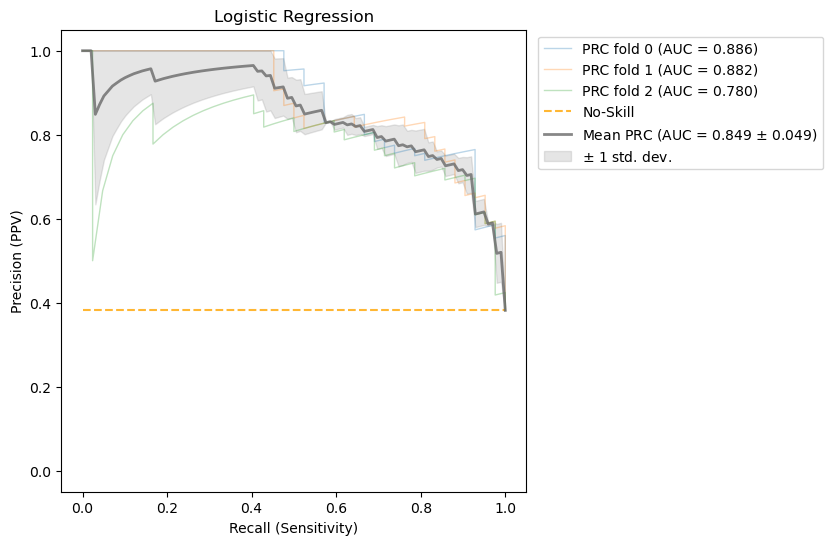

(-0.05, 1.05)

(-0.05, 1.05)

Text(0.5, 1.0, 'Naive Bayes')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

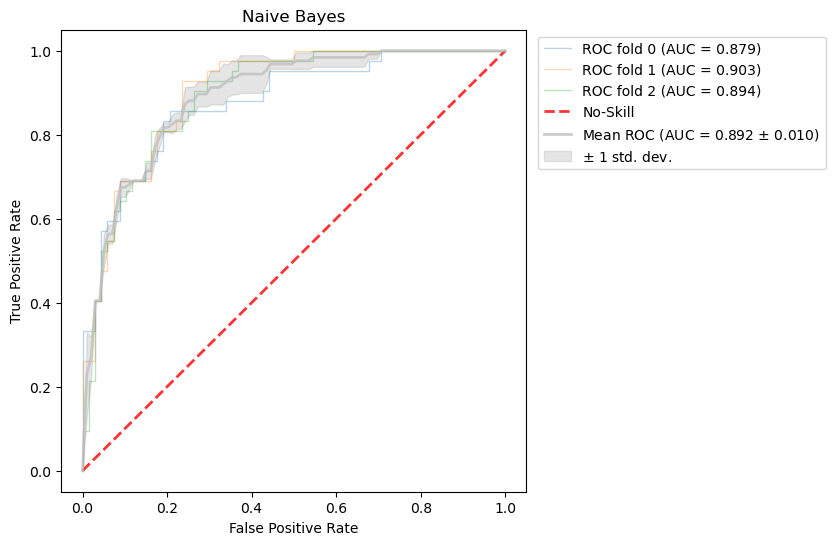

(-0.05, 1.05)

(-0.05, 1.05)

Text(0.5, 1.0, 'Naive Bayes')

Text(0.5, 0, 'Recall (Sensitivity)')

Text(0, 0.5, 'Precision (PPV)')

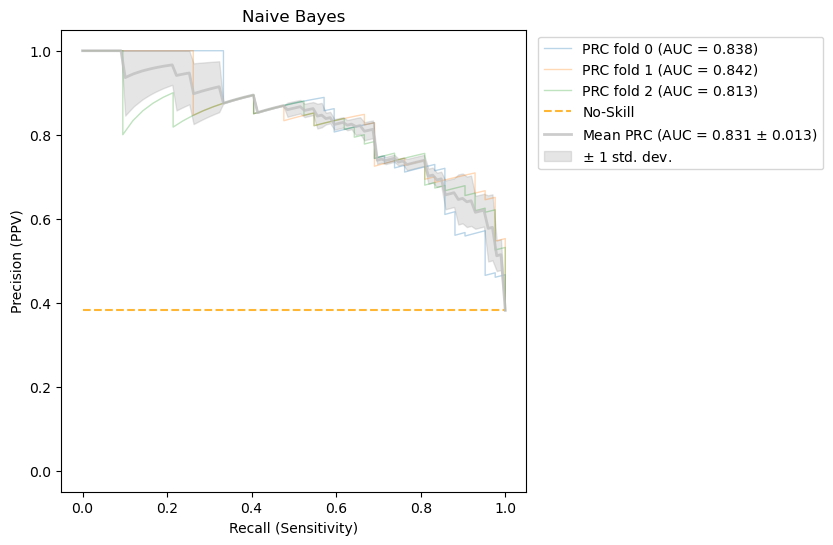

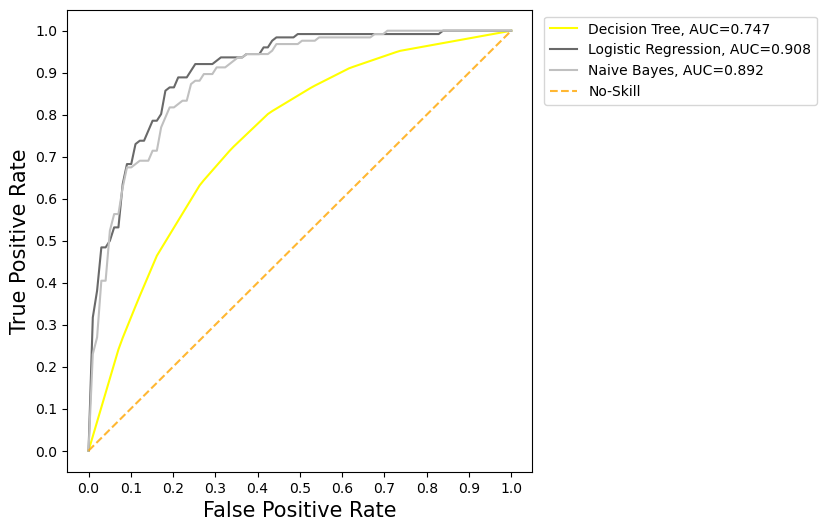

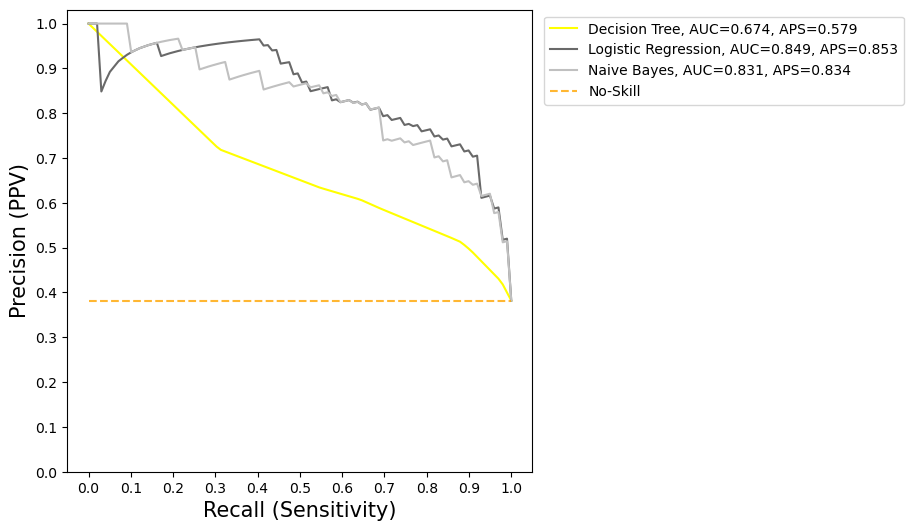

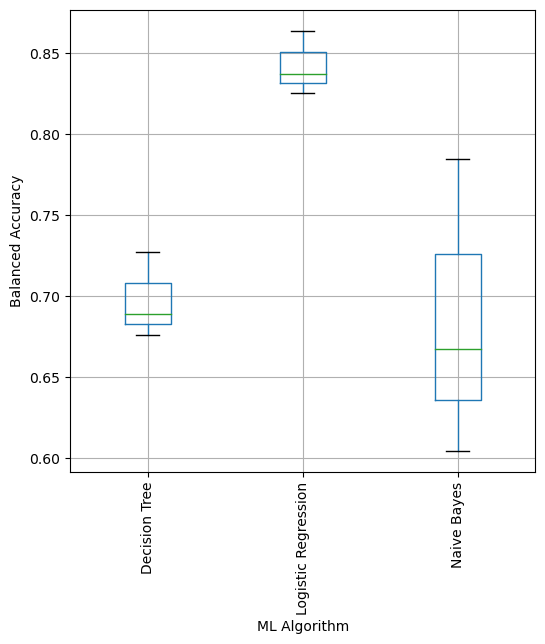

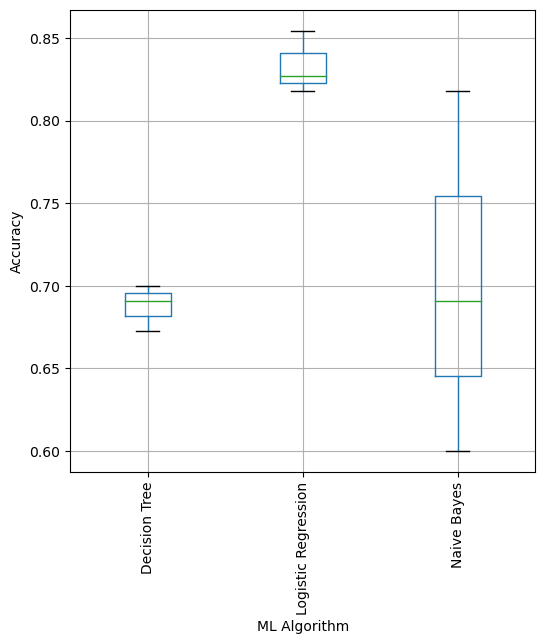

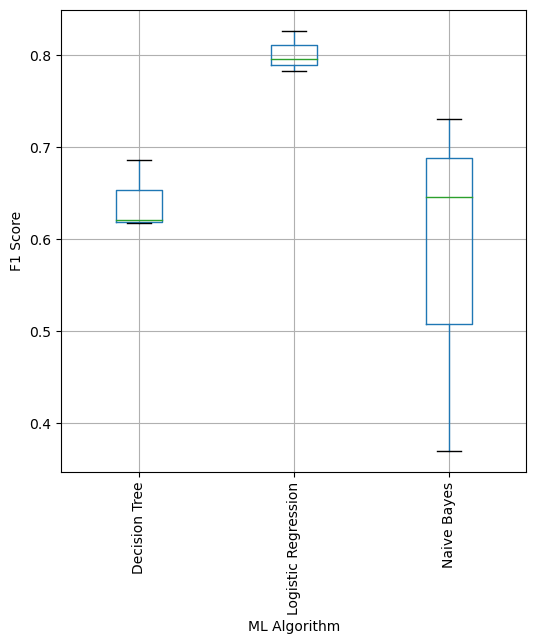

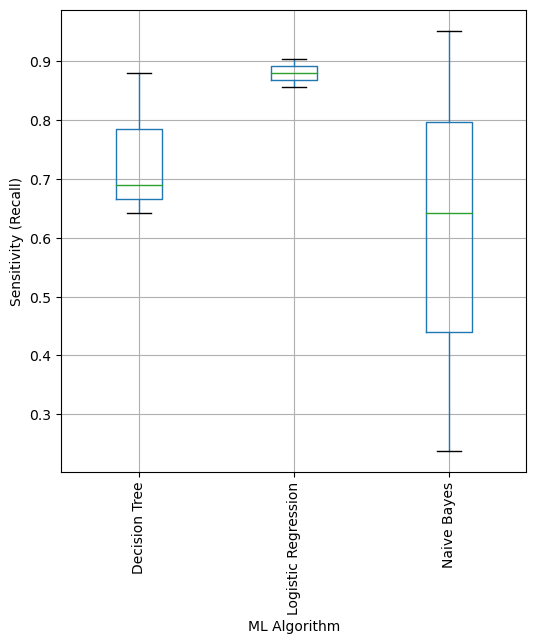

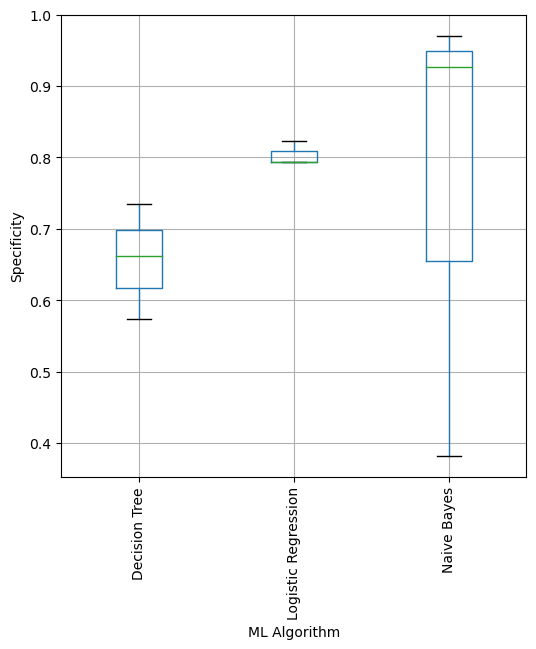

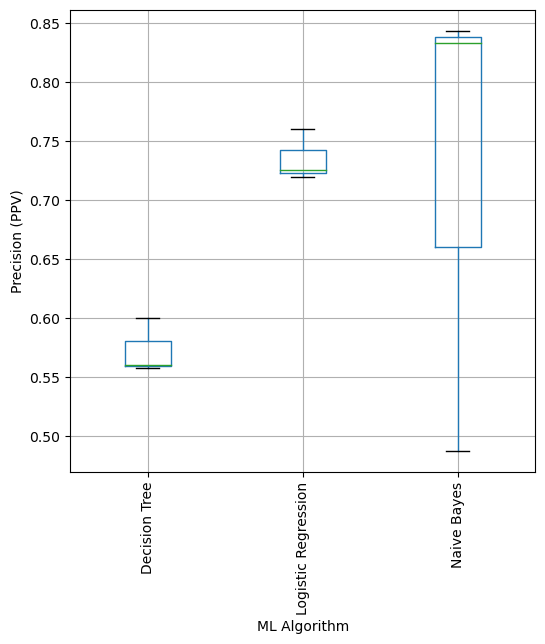

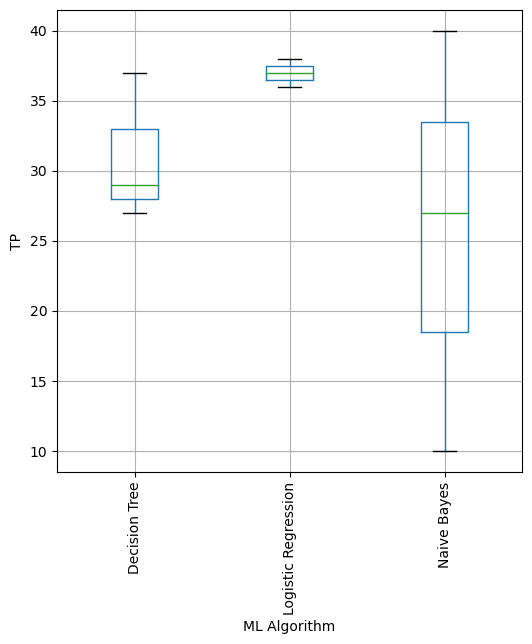

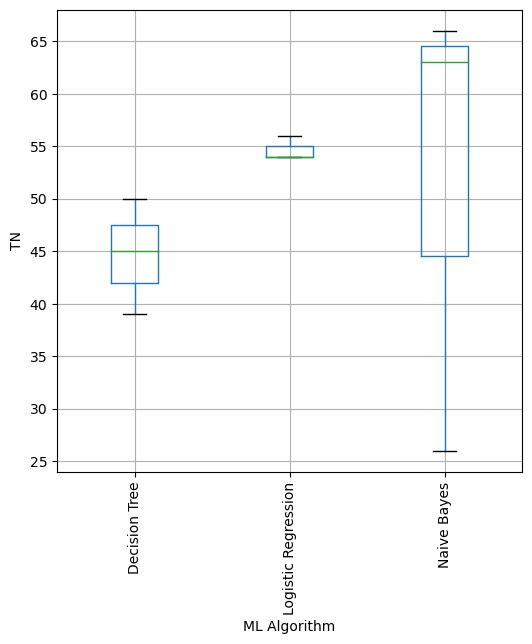

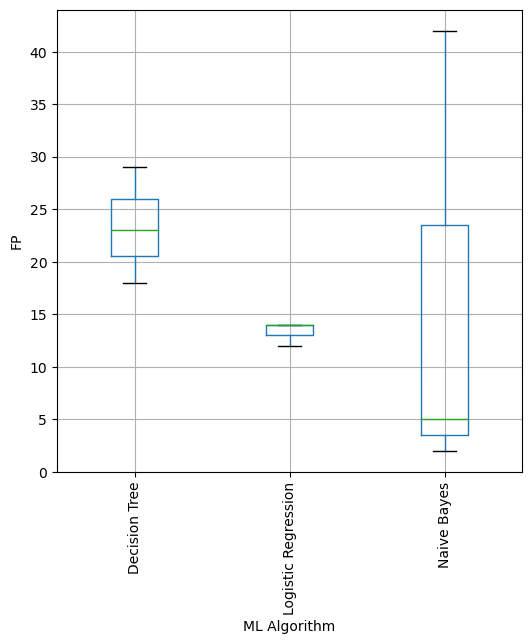

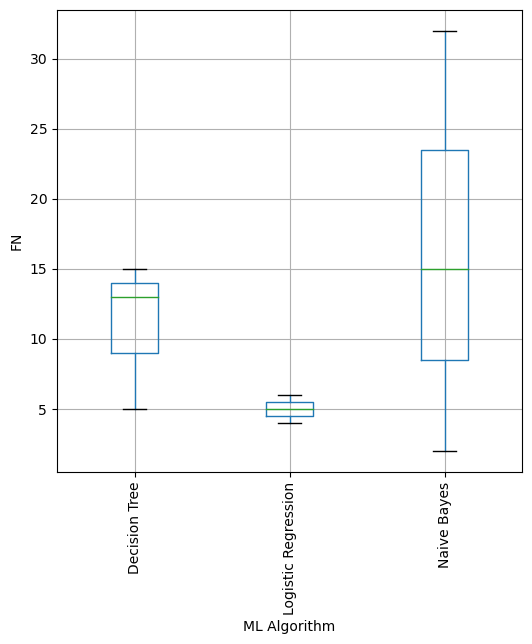

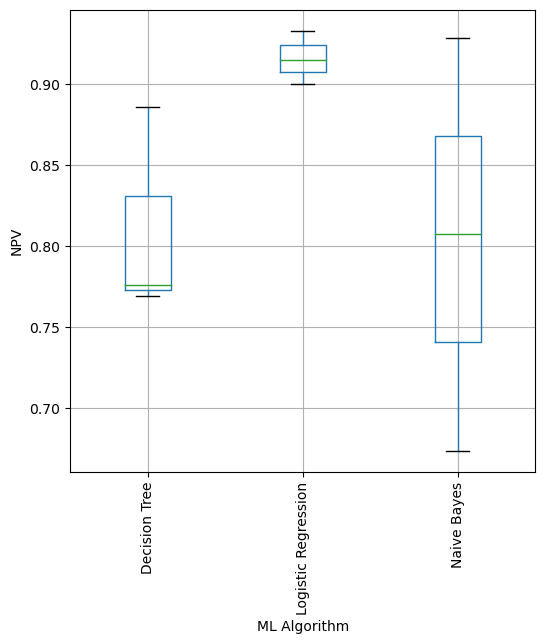

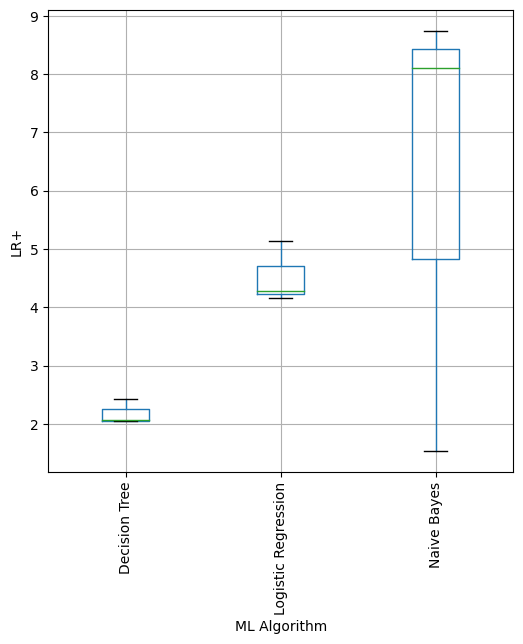

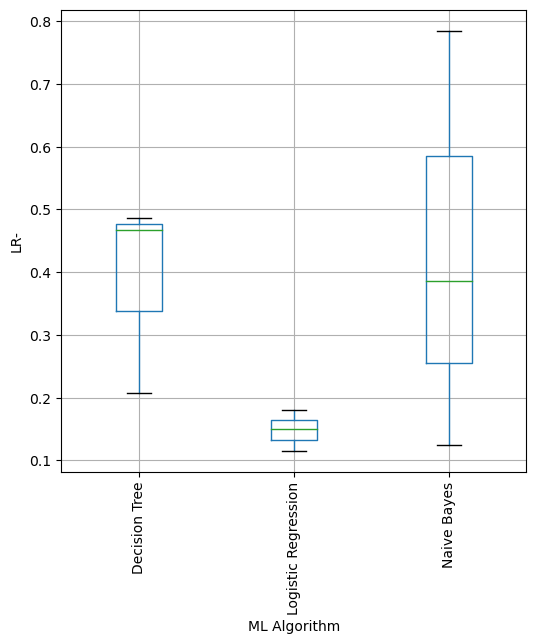

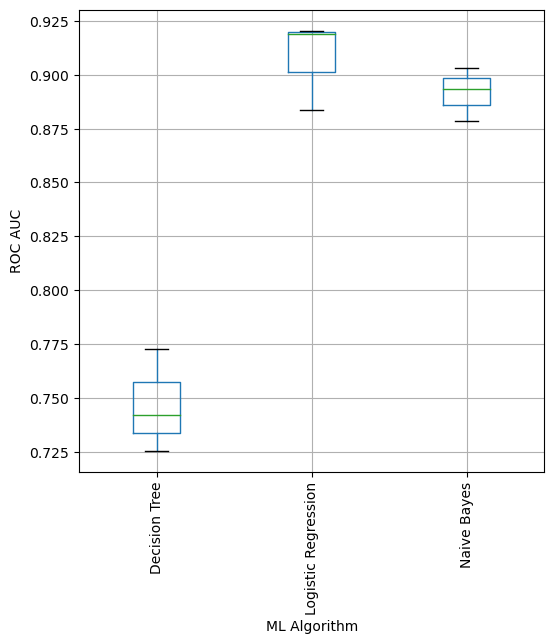

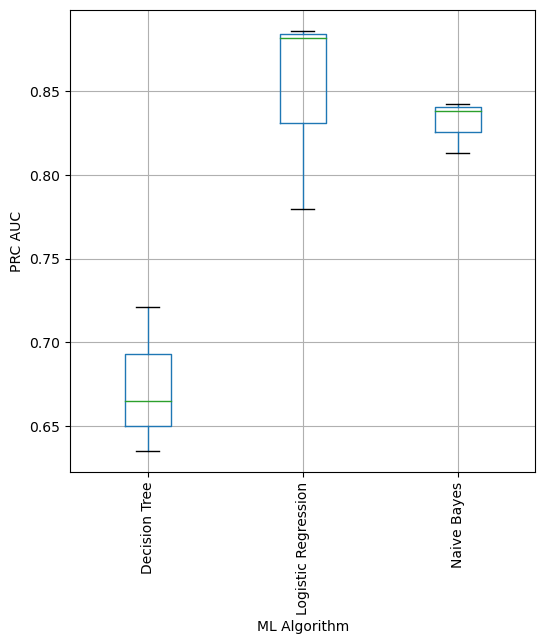

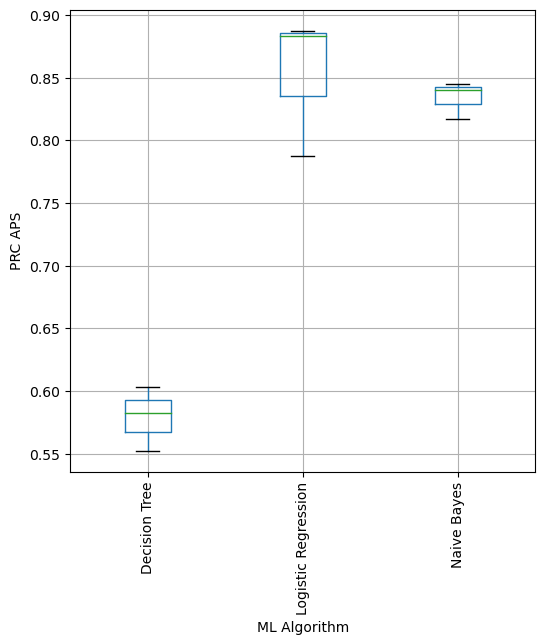

In [14]:
if not targetDataName == 'None': # User specified one analyzed dataset above (if more than one were analyzed)
    for each in datasets:
        if not each == targetDataName:
            datasets.remove(each)
    print("Vizualized Datasets: "+str(datasets))
    
for each in datasets: #each analyzed dataset to make plots for
    print("---------------------------------------")
    print(each)
    print("---------------------------------------")
    full_path = experiment_path+'/'+each
    
    #Create Folder to store training evaluation results
    if not os.path.exists(full_path+"/model_training_evaluation"):
        os.mkdir(full_path+"/model_training_evaluation")
    
    #Create folder for tree vizualization files
    original_headers = pd.read_csv(full_path+"/exploratory/OriginalFeatureNames.csv",sep=',').columns.values.tolist() #Get Original Headers
    metric_dict = {}
    result_table = []
    for algorithm in algorithms: #loop through algorithms
        alg_result_table = [] #stores values used in ROC and PRC plots
        # Define evaluation stats variable lists
        s_bac = [] # balanced accuracies
        s_ac = [] # standard accuracies
        s_f1 = [] # F1 scores
        s_re = [] # recall values
        s_sp = [] # specificities
        s_pr = [] # precision values
        s_tp = [] # true positives
        s_tn = [] # true negatives
        s_fp = [] # false positives
        s_fn = [] # false negatives
        s_npv = [] # negative predictive values
        s_lrp = [] # likelihood ratio positive values
        s_lrm = [] # likelihood ratio negative values
        # Define ROC plot variable lists
        tprs = [] # true postitive rates
        aucs = [] #areas under ROC curve
        mean_fpr = np.linspace(0, 1, 100) #used to plot all CVs in single ROC plot
        mean_recall = np.linspace(0, 1, 100) #used to plot all CVs in single PRC plot
        # Define PRC plot variable lists
        precs = [] #precision values for PRC
        praucs = [] #area under PRC curve
        aveprecs = [] #average precisions for PRC
        
        for cvCount in range(0,cv_partitions): #loop through cv's
            #load training data
            train_file_path = full_path + '/CVDatasets/' + each + "_CV_" + str(cvCount) + "_Train.csv"
            train = pd.read_csv(train_file_path)
            if instance_label != 'None':
                train = train.drop(instance_label,axis=1)
            trainX = train.drop(class_label,axis=1).values
            trainY = train[class_label].values
            del train #memory cleanup
            
            #Load pickled metric file for given algorithm and cv
            model_file = full_path+'/models/pickledModels/'+abbrev[algorithm]+"_"+str(cvCount)+'.pickle'
            file = open(model_file, 'rb')
            model = pickle.load(file)
            file.close()
        
            # Determine probabilities of class predictions for each train instance (this will be used much later in calculating an ROC curve)
            probas_ = model.predict_proba(trainX)

            #Get new class predictions given specified decision threshold
            y_pred = probas_[:,1] > threshold

            integer_map = map(int, y_pred) 
            integer_list = list(integer_map)

            #Calculate standard classificaction metrics
            metricList = classEval(trainY, y_pred)
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = metrics.roc_curve(trainY, probas_[:, 1])
            roc_auc = auc(fpr, tpr)
            # Compute Precision/Recall curve and AUC
            prec, recall, thresholds = metrics.precision_recall_curve(trainY, probas_[:, 1])
            prec, recall, thresholds = prec[::-1], recall[::-1], thresholds[::-1]
            prec_rec_auc = auc(recall, prec)
            ave_prec = metrics.average_precision_score(trainY, probas_[:, 1])

            #Separate metrics from metricList
            s_bac.append(metricList[0])
            s_ac.append(metricList[1])
            s_f1.append(metricList[2])
            s_re.append(metricList[3])
            s_sp.append(metricList[4])
            s_pr.append(metricList[5])
            s_tp.append(metricList[6])
            s_tn.append(metricList[7])
            s_fp.append(metricList[8])
            s_fn.append(metricList[9])
            s_npv.append(metricList[10])
            s_lrp.append(metricList[11])
            s_lrm.append(metricList[12])
            
            #update list that stores values used in ROC and PRC plots
            alg_result_table.append([fpr, tpr, roc_auc, prec, recall, prec_rec_auc, ave_prec])
            # Update ROC plot variable lists needed to plot all CVs in one ROC plot
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            aucs.append(roc_auc)
            # Update PRC plot variable lists needed to plot all CVs in one PRC plot
            precs.append(interp(mean_recall, recall, prec))
            praucs.append(prec_rec_auc)
            aveprecs.append(ave_prec)

        # Define values for the mean ROC line (mean of individual CVs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        # Generate ROC Plot (including individual CV's lines, average line, and no skill line) - 
        # based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html-----------------------
        if plot_ROC:
            # Set figure dimensions
            plt.rcParams["figure.figsize"] = (6,6)
            # Plot individual CV ROC lines
            for i in range(cv_partitions):
                plt.plot(alg_result_table[i][0], alg_result_table[i][1], lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.3f)' % (i, alg_result_table[i][2]))
            # Plot no-skill line
            plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='No-Skill', alpha=.8)
            # Plot average line for all CVs
            std_auc = np.std(aucs) # AUC standard deviations across CVs
            plt.plot(mean_fpr, mean_tpr, color=colors[algorithm],label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),lw=2, alpha=.8)
            # Plot standard deviation grey zone of curves
            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
            #Specify plot axes,labels, and legend
            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
            plt.title(str(algorithm))
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc="upper left", bbox_to_anchor=(1.01,1))
            #Export and/or show plot
            plt.savefig(full_path+'/model_training_evaluation/'+abbrev[algorithm]+"_ROC.png", bbox_inches="tight")
            plt.show()

        #Define values for the mean PRC line (mean of individual CVs)
        mean_prec = np.mean(precs, axis=0)
        mean_pr_auc = np.mean(praucs)
        #Generate PRC Plot (including individual CV's lines, average line, and no skill line)------------------------------------------------------------------------------------------------------------------
        if plot_PRC:
            # Set figure dimensions
            plt.rcParams["figure.figsize"] = (6,6)
            # Plot individual CV PRC lines
            for i in range(cv_partitions):
                plt.plot(alg_result_table[i][4], alg_result_table[i][3], lw=1, alpha=0.3, label='PRC fold %d (AUC = %0.3f)' % (i, alg_result_table[i][5]))
            #Estimate no skill line based on the fraction of cases found in the first test dataset
            test = pd.read_csv(full_path + '/CVDatasets/' + each + '_CV_0_Train.csv') #Technically there could be a unique no-skill line for each CV dataset based on final class balance (however only one is needed, and stratified CV attempts to keep partitions with similar/same class balance)
            testY = test[class_label].values
            noskill = len(testY[testY == 1]) / len(testY)  # Fraction of cases
            # Plot no-skill line
            plt.plot([0, 1], [noskill, noskill], color='orange', linestyle='--', label='No-Skill', alpha=.8)
            # Plot average line for all CVs
            std_pr_auc = np.std(praucs)
            # Plot standard deviation grey zone of curves
            plt.plot(mean_recall, mean_prec, color=colors[algorithm],label=r'Mean PRC (AUC = %0.3f $\pm$ %0.3f)' % (mean_pr_auc, std_pr_auc),lw=2, alpha=.8)
            std_prec = np.std(precs, axis=0)
            precs_upper = np.minimum(mean_prec + std_prec, 1)
            precs_lower = np.maximum(mean_prec - std_prec, 0)
            plt.fill_between(mean_recall, precs_lower, precs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
            #Specify plot axes,labels, and legend
            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
            plt.title(str(algorithm))
            plt.xlabel('Recall (Sensitivity)')
            plt.ylabel('Precision (PPV)')
            plt.legend(loc="upper left", bbox_to_anchor=(1.01,1))
            #Export and/or show plot
            plt.savefig(full_path+'/model_training_evaluation/'+abbrev[algorithm]+"_PRC.png", bbox_inches="tight")
            plt.show()
                
        #Export and save all CV metric stats for each individual algorithm  -----------------------------------------------------------------------------
        results = {'Balanced Accuracy': s_bac, 'Accuracy': s_ac, 'F1 Score': s_f1, 'Sensitivity (Recall)': s_re, 'Specificity': s_sp,'Precision (PPV)': s_pr, 'TP': s_tp, 'TN': s_tn, 'FP': s_fp, 'FN': s_fn, 'NPV': s_npv, 'LR+': s_lrp, 'LR-': s_lrm, 'ROC AUC': aucs,'PRC AUC': praucs, 'PRC APS': aveprecs}
        dr = pd.DataFrame(results)
        filepath = full_path+'/model_training_evaluation/'+abbrev[algorithm]+"_performance"+name_modifier+".csv"
        dr.to_csv(filepath, header=True, index=False)
        
        #add to metric list
        metric_dict[algorithm] = results
        
        #Store ave metrics for creating global ROC and PRC plots later
        mean_ave_prec = np.mean(aveprecs)
        result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'recall':mean_recall, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
        result_table.append(result_dict)
        
    #Result table later used to create global ROC an PRC plots comparing average ML algorithm performance.
    result_table = pd.DataFrame.from_dict(result_table)
    result_table.set_index('algorithm',inplace=True)

    #Make list of metric names
    my_metrics = list(metric_dict[algorithms[0]].keys())
    
    #Plot ROC and PRC curves comparing average ML algorithm performance (averaged over all CVs)
    doPlotROC(result_table,colors,full_path)
    doPlotPRC(result_table,colors,full_path,each,instance_label,class_label)
    
    #Save metric means and standard deviations
    saveMetricMeans(full_path,my_metrics,metric_dict,name_modifier)
    saveMetricStd(full_path,my_metrics,metric_dict,name_modifier)
    
    #Generate boxplots comparing algorithm performance for each standard metric, if specified by user
    if plot_metric_boxplots:
        metricBoxplots(full_path,my_metrics,algorithms,metric_dict,name_modifier)    
        
    #Calculate and export Kruskal Wallis, Mann Whitney, and wilcoxon Rank sum stats if more than one ML algorithm has been run (for the comparison) - note stats are based on comparing the multiple CV models for each algorithm.
    if run_sig_test:
        if len(algorithms) > 1:
            kruskal_summary = kruskalWallis(full_path,my_metrics,algorithms,metric_dict,sig_cutoff,name_modifier)
            wilcoxonRank(full_path,my_metrics,algorithms,metric_dict,kruskal_summary,sig_cutoff,name_modifier)
            mannWhitneyU(full_path,my_metrics,algorithms,metric_dict,kruskal_summary,sig_cutoff,name_modifier)
        